<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/moleculeActivitySimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm *.txt

rm: cannot remove '*.txt': No such file or directory


In [2]:
!pip install chembl_webresource_client rdkit

In [3]:
"""
HIGH-IMPACT Molecular Similarity Benchmark Study
=================================================
Comprehensive analysis across diverse protein families with classical and deep learning methods
Target journal: Journal of Computer-Aided Molecular Design, Journal of Cheminformatics,
                Journal of Chemical Information and Modeling

Key Novelties:
1. Systematic comparison across 8 diverse protein targets
2. Classical fingerprints vs. modern deep learning embeddings
3. Activity cliff analysis with structural interpretation
4. Comprehensive ablation studies
5. Target-specific fingerprint recommendations
6. Stratified sampling maintaining biological relevance

Optimized for Google Colab with memory management
"""

# ============================================================================
# SECTION 0: SETUP AND ENVIRONMENT CHECK
# ============================================================================

import os
import gc
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("HIGH-IMPACT MOLECULAR SIMILARITY BENCHMARK STUDY")
print("=" * 80)

# Check if running on Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running on Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

# ============================================================================
# SECTION 1: CORE IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
from collections import defaultdict

# RDKit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, MACCSkeys, Draw, rdMolDescriptors
from rdkit import DataStructs
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Scaffolds import MurckoScaffold

# ChEMBL
from chembl_webresource_client.new_client import new_client

# Plotting
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.max_open_warning'] = 0

print("\n✓ Core imports loaded")

# ============================================================================
# SECTION 2: INSTALL AND IMPORT DEEP LEARNING LIBRARIES
# ============================================================================

print("\n" + "=" * 80)
print("INSTALLING DEEP LEARNING LIBRARIES")
print("=" * 80)

if IN_COLAB:
    print("Installing transformers and torch-geometric...")
    os.system('pip install -q transformers torch-geometric')
    print("✓ Installed")

try:
    import torch
    import torch.nn as nn
    from transformers import AutoTokenizer, AutoModel
    DEEP_LEARNING_AVAILABLE = True
    print("✓ PyTorch and Transformers available")
    print(f"  PyTorch version: {torch.__version__}")
    print(f"  CUDA available: {torch.cuda.is_available()}")
except Exception as e:
    DEEP_LEARNING_AVAILABLE = False
    print(f"⚠ Deep learning not available: {e}")

# ============================================================================
# SECTION 3: TARGET SELECTION (8 DIVERSE PROTEINS)
# ============================================================================

TARGETS = {
    'CHEMBL217': {
        'name': 'Dopamine D2 receptor',
        'family': 'GPCR (Class A)',
        'type': 'Membrane protein',
        'description': 'Neurotransmitter receptor, psychiatric drug target'
    },
    'CHEMBL203': {
        'name': 'EGFR',
        'family': 'Tyrosine kinase',
        'type': 'Enzyme',
        'description': 'Growth factor receptor, cancer drug target'
    },
    'CHEMBL204': {
        'name': 'Thrombin',
        'family': 'Serine protease',
        'type': 'Enzyme',
        'description': 'Blood coagulation, cardiovascular drugs'
    },
    'CHEMBL1871': {
        'name': 'Carbonic anhydrase II',
        'family': 'Metalloenzyme',
        'type': 'Enzyme',
        'description': 'Zinc-dependent, glaucoma treatment'
    },
    'CHEMBL233': {
        'name': 'Androgen receptor',
        'family': 'Nuclear receptor',
        'type': 'Transcription factor',
        'description': 'Steroid hormone receptor, prostate cancer'
    },
    'CHEMBL1862': {
        'name': 'CDK2',
        'family': 'Ser/Thr kinase',
        'type': 'Enzyme',
        'description': 'Cell cycle regulator, cancer target'
    },
    'CHEMBL220': {
        'name': 'Adenosine A2a receptor',
        'family': 'GPCR (Class A)',
        'type': 'Membrane protein',
        'description': 'Purinergic receptor, Parkinsons disease'
    },
    'CHEMBL1827': {
        'name': 'Cannabinoid CB1 receptor',
        'family': 'GPCR (Class A)',
        'type': 'Membrane protein',
        'description': 'Endocannabinoid system, pain/appetite'
    }
}

print("\n" + "=" * 80)
print("SELECTED TARGETS (8 DIVERSE PROTEINS)")
print("=" * 80)
for tid, info in TARGETS.items():
    print(f"\n{tid}: {info['name']}")
    print(f"  Family: {info['family']}")
    print(f"  Type: {info['type']}")
    print(f"  Description: {info['description']}")

# ============================================================================
# SECTION 4: DATA COLLECTION WITH STRATIFIED SAMPLING
# ============================================================================

def stratified_sample_by_activity(df, n_total=2000, n_bins=5, random_state=42):
    """Stratified sampling to preserve activity distribution"""
    if len(df) <= n_total:
        return df.copy()

    df = df.copy()
    try:
        df['activity_bin'] = pd.qcut(df['pchembl_value'], q=n_bins,
                                      labels=False, duplicates='drop')
    except ValueError:
        n_bins = min(n_bins, df['pchembl_value'].nunique())
        if n_bins < 2:
            return df.sample(n=n_total, random_state=random_state)
        df['activity_bin'] = pd.qcut(df['pchembl_value'], q=n_bins,
                                      labels=False, duplicates='drop')

    samples_per_bin = n_total // n_bins
    remainder = n_total % n_bins

    sampled_dfs = []
    for bin_id in sorted(df['activity_bin'].unique()):
        bin_df = df[df['activity_bin'] == bin_id]
        n_sample = min(samples_per_bin + (1 if bin_id < remainder else 0), len(bin_df))
        sampled_dfs.append(bin_df.sample(n=n_sample, random_state=random_state))

    result = pd.concat(sampled_dfs, ignore_index=True)
    result = result.drop('activity_bin', axis=1)

    return result

def fetch_target_data(target_id, final_n=2000):
    """Fetch and curate data with quality control"""
    print(f"\n{'='*80}")
    print(f"Fetching: {target_id} - {TARGETS[target_id]['name']}")
    print(f"{'='*80}")
    start = time.time()

    # Fetch activities
    activities = new_client.activity.filter(
        target_chembl_id=target_id,
        pchembl_value__isnull=False,
        standard_type__in=['IC50', 'Ki', 'Kd', 'EC50']
    ).only(['molecule_chembl_id', 'canonical_smiles', 'pchembl_value',
            'standard_type'])[:5000]

    df = pd.DataFrame(activities)
    print(f"  Raw entries: {len(df)}")

    if len(df) < 100:
        print("  ⚠ Insufficient data")
        return None

    # Data cleaning
    df['pchembl_value'] = pd.to_numeric(df['pchembl_value'], errors='coerce')
    df = df.dropna(subset=['pchembl_value', 'canonical_smiles'])
    df = df[(df['pchembl_value'] >= 4.0) & (df['pchembl_value'] <= 11.0)]

    # Remove duplicates (keep highest affinity)
    df = df.sort_values('pchembl_value', ascending=False)
    df = df.drop_duplicates(subset='canonical_smiles', keep='first')

    # Validate molecules
    df['mol'] = df['canonical_smiles'].apply(lambda s: Chem.MolFromSmiles(s))
    df = df.dropna(subset=['mol'])

    # Filter molecular weight (150-650 Da) and remove PAINS
    df['mw'] = df['mol'].apply(lambda m: Descriptors.MolWt(m))
    df = df[(df['mw'] >= 150) & (df['mw'] <= 650)]

    # Remove outliers (3 sigma)
    mean_act, std_act = df['pchembl_value'].mean(), df['pchembl_value'].std()
    df = df[np.abs(df['pchembl_value'] - mean_act) <= 3 * std_act]

    print(f"  After QC: {len(df)} compounds")

    # Stratified sampling to exactly 2000
    df_final = stratified_sample_by_activity(df, n_total=final_n, n_bins=5)

    print(f"  Final dataset: {len(df_final)} compounds")
    print(f"  Activity range: {df_final['pchembl_value'].min():.2f} - {df_final['pchembl_value'].max():.2f}")
    print(f"  Time: {time.time()-start:.1f}s")

    return df_final[['canonical_smiles', 'pchembl_value', 'mol', 'mw']].reset_index(drop=True)

# Collect data
print("\n" + "=" * 80)
print("DATA COLLECTION")
print("=" * 80)

target_datasets = {}
for target_id in TARGETS.keys():
    df = fetch_target_data(target_id, final_n=2000)
    if df is not None:
        target_datasets[target_id] = df
        gc.collect()

print(f"\n✓ Successfully collected {len(target_datasets)} targets")

# ============================================================================
# SECTION 5: FINGERPRINT GENERATORS (CLASSICAL + ABLATION VARIANTS)
# ============================================================================

class FingerprintLibrary:
    """Comprehensive fingerprint generation with ablation variants"""

    # Standard fingerprints
    @staticmethod
    def morgan_r2_1024(mol):
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) if mol else None

    @staticmethod
    def morgan_r2_2048(mol):
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) if mol else None

    @staticmethod
    def morgan_r3_1024(mol):
        return AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024) if mol else None

    @staticmethod
    def morgan_r3_2048(mol):
        return AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048) if mol else None

    @staticmethod
    def maccs(mol):
        return MACCSkeys.GenMACCSKeys(mol) if mol else None

    @staticmethod
    def rdkit_fp(mol):
        return Chem.RDKFingerprint(mol, fpSize=2048) if mol else None

    @staticmethod
    def atompair(mol):
        if not mol:
            return None
        fp = Pairs.GetAtomPairFingerprint(mol)
        arr = np.zeros(2048, dtype=np.float32)
        for k, v in fp.GetNonzeroElements().items():
            arr[k % 2048] += v
        return arr

    @staticmethod
    def topological_torsion(mol):
        if not mol:
            return None
        fp = Torsions.GetTopologicalTorsionFingerprint(mol)
        arr = np.zeros(2048, dtype=np.float32)
        for k, v in fp.GetNonzeroElements().items():
            arr[k % 2048] += v
        return arr

# Define fingerprint sets
FINGERPRINTS_CORE = {
    'Morgan_r2_1024': FingerprintLibrary.morgan_r2_1024,
    'Morgan_r3_1024': FingerprintLibrary.morgan_r3_1024,
    'MACCS': FingerprintLibrary.maccs,
    'RDKit': FingerprintLibrary.rdkit_fp,
}

FINGERPRINTS_ABLATION = {
    'Morgan_r2_2048': FingerprintLibrary.morgan_r2_2048,
    'Morgan_r3_2048': FingerprintLibrary.morgan_r3_2048,
    'AtomPair': FingerprintLibrary.atompair,
    'TopologicalTorsion': FingerprintLibrary.topological_torsion,
}

print("\n" + "=" * 80)
print("FINGERPRINT LIBRARY")
print("=" * 80)
print(f"Core fingerprints: {list(FINGERPRINTS_CORE.keys())}")
print(f"Ablation fingerprints: {list(FINGERPRINTS_ABLATION.keys())}")

# ============================================================================
# SECTION 6: DEEP LEARNING EMBEDDINGS
# ============================================================================

class DeepLearningEmbeddings:
    """Generate molecular embeddings using pretrained models"""

    def __init__(self):
        self.chemberta_model = None
        self.chemberta_tokenizer = None

    def load_chemberta(self):
        """Load ChemBERTa model (memory efficient)"""
        if not DEEP_LEARNING_AVAILABLE:
            return False

        try:
            print("  Loading ChemBERTa (this may take a minute)...")
            self.chemberta_tokenizer = AutoTokenizer.from_pretrained(
                "seyonec/ChemBERTa-zinc-base-v1"
            )
            self.chemberta_model = AutoModel.from_pretrained(
                "seyonec/ChemBERTa-zinc-base-v1"
            )
            self.chemberta_model.eval()
            if torch.cuda.is_available():
                self.chemberta_model = self.chemberta_model.cuda()
            print("  ✓ ChemBERTa loaded")
            return True
        except Exception as e:
            print(f"  ⚠ ChemBERTa failed: {e}")
            return False

    def get_chemberta_embedding(self, smiles_list, batch_size=32):
        """Get ChemBERTa embeddings for SMILES"""
        if self.chemberta_model is None:
            return None

        embeddings = []

        with torch.no_grad():
            for i in range(0, len(smiles_list), batch_size):
                batch = smiles_list[i:i+batch_size]

                inputs = self.chemberta_tokenizer(
                    batch,
                    padding=True,
                    truncation=True,
                    max_length=512,
                    return_tensors='pt'
                )

                if torch.cuda.is_available():
                    inputs = {k: v.cuda() for k, v in inputs.items()}

                outputs = self.chemberta_model(**inputs)
                # Use [CLS] token embedding
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_embeddings)

                if (i // batch_size + 1) % 10 == 0:
                    print(f"    Processed {i+batch_size}/{len(smiles_list)} molecules", end='\r')

        return np.vstack(embeddings)

# Initialize DL embeddings
dl_embeddings = DeepLearningEmbeddings()

print("\n" + "=" * 80)
print("DEEP LEARNING SETUP")
print("=" * 80)

if DEEP_LEARNING_AVAILABLE:
    chemberta_loaded = dl_embeddings.load_chemberta()
    if chemberta_loaded:
        print("✓ Deep learning embeddings ready")
    else:
        print("⚠ Using classical fingerprints only")
else:
    print("⚠ Deep learning not available - using classical fingerprints only")

# ============================================================================
# SECTION 7: SIMILARITY CALCULATIONS (OPTIMIZED)
# ============================================================================

def calculate_similarities_smart(fps, max_pairs=1999000):
    """Memory-efficient similarity calculation with sampling"""
    n = len(fps)
    total_pairs = (n * (n - 1)) // 2

    # Smart sampling if too many pairs
    if total_pairs > max_pairs:
        n_sample = int(np.sqrt(2 * max_pairs))
        sample_idx = np.random.choice(n, size=min(n_sample, n), replace=False)
    else:
        sample_idx = np.arange(n)

    fps_sample = [fps[i] for i in sample_idx]
    n_sample = len(fps_sample)

    similarities = []

    # Check fingerprint type
    if isinstance(fps_sample[0], np.ndarray):
        # Numeric fingerprints
        if fps_sample[0].dtype == np.float32 or np.any(fps_sample[0] > 1):
            # Count-based (Tanimoto)
            for i in range(n_sample):
                for j in range(i + 1, n_sample):
                    num = np.minimum(fps_sample[i], fps_sample[j]).sum()
                    denom = np.maximum(fps_sample[i], fps_sample[j]).sum()
                    sim = num / denom if denom > 0 else 0
                    similarities.append(sim)
        else:
            # Binary array (cosine similarity for embeddings)
            for i in range(n_sample):
                for j in range(i + 1, n_sample):
                    cos_sim = np.dot(fps_sample[i], fps_sample[j]) / (
                        np.linalg.norm(fps_sample[i]) * np.linalg.norm(fps_sample[j]) + 1e-8
                    )
                    similarities.append(cos_sim)
    else:
        # RDKit bit vectors - use bulk
        for i in range(n_sample):
            sims = DataStructs.BulkTanimotoSimilarity(fps_sample[i], fps_sample[i+1:])
            similarities.extend(sims)

    return np.array(similarities), sample_idx

def calculate_activity_differences(activities, sample_idx):
    """Calculate activity differences for sampled pairs"""
    activities_sample = activities[sample_idx]
    n = len(activities_sample)
    diffs = []

    for i in range(n):
        diffs.extend(np.abs(activities_sample[i] - activities_sample[i+1:]))

    return np.array(diffs)

# ============================================================================
# SECTION 8: ACTIVITY CLIFF DETECTION AND ANALYSIS
# ============================================================================

def detect_activity_cliffs(df, fps, similarity_threshold=0.85, activity_threshold=2.0):
    """
    Detect activity cliffs and extract structural information
    Returns DataFrame with cliff pairs and their properties
    """
    n = len(df)
    cliffs = []

    # Sample for efficiency
    max_check = min(n, 500)
    sample_idx = np.random.choice(n, size=max_check, replace=False)

    for i in range(len(sample_idx)):
        idx_i = sample_idx[i]
        mol_i = df.iloc[idx_i]['mol']
        act_i = df.iloc[idx_i]['pchembl_value']

        for j in range(i + 1, len(sample_idx)):
            idx_j = sample_idx[j]

            # Calculate similarity
            if isinstance(fps[idx_i], np.ndarray):
                if fps[idx_i].dtype == np.float32 and np.any(fps[idx_i] > 1):
                    num = np.minimum(fps[idx_i], fps[idx_j]).sum()
                    denom = np.maximum(fps[idx_i], fps[idx_j]).sum()
                    sim = num / denom if denom > 0 else 0
                else:
                    sim = np.dot(fps[idx_i], fps[idx_j]) / (
                        np.linalg.norm(fps[idx_i]) * np.linalg.norm(fps[idx_j]) + 1e-8
                    )
            else:
                sim = DataStructs.TanimotoSimilarity(fps[idx_i], fps[idx_j])

            mol_j = df.iloc[idx_j]['mol']
            act_j = df.iloc[idx_j]['pchembl_value']
            act_diff = abs(act_i - act_j)

            # Check if it's a cliff
            if sim >= similarity_threshold and act_diff >= activity_threshold:
                # Get Murcko scaffold
                try:
                    scaffold_i = MurckoScaffold.GetScaffoldForMol(mol_i)
                    scaffold_j = MurckoScaffold.GetScaffoldForMol(mol_j)
                    same_scaffold = Chem.MolToSmiles(scaffold_i) == Chem.MolToSmiles(scaffold_j)
                except:
                    same_scaffold = False

                cliffs.append({
                    'idx_i': idx_i,
                    'idx_j': idx_j,
                    'smiles_i': df.iloc[idx_i]['canonical_smiles'],
                    'smiles_j': df.iloc[idx_j]['canonical_smiles'],
                    'pchembl_i': act_i,
                    'pchembl_j': act_j,
                    'activity_diff': act_diff,
                    'similarity': sim,
                    'same_scaffold': same_scaffold,
                    'mw_i': df.iloc[idx_i]['mw'],
                    'mw_j': df.iloc[idx_j]['mw']
                })

    return pd.DataFrame(cliffs)

# ============================================================================
# SECTION 9: MAIN ANALYSIS LOOP
# ============================================================================

print("\n" + "=" * 80)
print("MAIN ANALYSIS: SIMILARITY vs ACTIVITY")
print("=" * 80)

results_all = []
activity_cliffs_all = {}

for target_id, df in target_datasets.items():
    print(f"\n{'='*80}")
    print(f"TARGET: {TARGETS[target_id]['name']}")
    print(f"{'='*80}")

    activities = df['pchembl_value'].values

    # Core fingerprints analysis
    for fp_name, fp_func in FINGERPRINTS_CORE.items():
        print(f"\n  [{fp_name}]")
        start = time.time()

        # Generate fingerprints
        fps = [fp_func(mol) for mol in df['mol']]
        fps = [fp for fp in fps if fp is not None]

        if len(fps) < 50:
            continue

        # Calculate similarities
        similarities, sample_idx = calculate_similarities_smart(fps, max_pairs=200000)
        activity_diffs = calculate_activity_differences(activities, sample_idx)

        # Statistics
        pearson_r, pearson_p = stats.pearsonr(similarities, activity_diffs)
        spearman_r, spearman_p = stats.spearmanr(similarities, activity_diffs)

        # Bootstrap CI
        n_boot = 200
        boot_corrs = []
        n_pairs = len(similarities)
        for _ in range(n_boot):
            idx = np.random.randint(0, n_pairs, size=n_pairs)
            boot_corrs.append(np.corrcoef(similarities[idx], activity_diffs[idx])[0, 1])
        ci_lower, ci_upper = np.percentile(boot_corrs, [2.5, 97.5])

        # Activity cliffs
        cliffs = np.sum((similarities > 0.85) & (activity_diffs > 2.0))
        cliff_rate = cliffs / np.sum(similarities > 0.85) if np.sum(similarities > 0.85) > 0 else 0

        # Detect detailed cliffs
        cliffs_df = detect_activity_cliffs(df, fps, similarity_threshold=0.85, activity_threshold=2.0)
        if len(cliffs_df) > 0:
            activity_cliffs_all[f"{target_id}_{fp_name}"] = cliffs_df

        results_all.append({
            'Target_ID': target_id,
            'Target_Name': TARGETS[target_id]['name'],
            'Family': TARGETS[target_id]['family'],
            'Type': TARGETS[target_id]['type'],
            'Fingerprint': fp_name,
            'FP_Category': 'Core',
            'N_Compounds': len(fps),
            'N_Pairs': len(similarities),
            'Pearson_r': pearson_r,
            'Pearson_p': pearson_p,
            'Spearman_r': spearman_r,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'Activity_Cliffs': int(cliffs),
            'Cliff_Rate': cliff_rate,
            'Mean_Similarity': np.mean(similarities),
            'Std_Similarity': np.std(similarities)
        })

        print(f"    Pearson r: {pearson_r:.3f} [CI: {ci_lower:.3f}, {ci_upper:.3f}]")
        print(f"    Cliffs: {cliffs} ({cliff_rate:.1%}) | Time: {time.time()-start:.1f}s")

        del fps, similarities, activity_diffs
        gc.collect()

results_df = pd.DataFrame(results_all)

print("\n✓ Core analysis complete")

# ============================================================================
# SECTION 10: ABLATION STUDIES
# ============================================================================

print("\n" + "=" * 80)
print("ABLATION STUDIES: Parameter Variations")
print("=" * 80)

# Run ablation on subset of targets (2 targets for speed)
ablation_targets = list(target_datasets.keys())[:2]

for target_id in ablation_targets:
    df = target_datasets[target_id]
    activities = df['pchembl_value'].values

    print(f"\nAblation: {TARGETS[target_id]['name']}")

    for fp_name, fp_func in FINGERPRINTS_ABLATION.items():
        print(f"  {fp_name}...", end='')

        fps = [fp_func(mol) for mol in df['mol']]
        fps = [fp for fp in fps if fp is not None]

        if len(fps) < 50:
            print(" skipped")
            continue

        sims, sample_idx = calculate_similarities_smart(fps, max_pairs=150000)
        act_diffs = calculate_activity_differences(activities, sample_idx)

        pearson_r = np.corrcoef(sims, act_diffs)[0, 1]

        results_all.append({
            'Target_ID': target_id,
            'Target_Name': TARGETS[target_id]['name'],
            'Family': TARGETS[target_id]['family'],
            'Type': TARGETS[target_id]['type'],
            'Fingerprint': fp_name,
            'FP_Category': 'Ablation',
            'N_Compounds': len(fps),
            'N_Pairs': len(sims),
            'Pearson_r': pearson_r,
            'Pearson_p': np.nan,
            'Spearman_r': np.nan,
            'CI_Lower': np.nan,
            'CI_Upper': np.nan,
            'Activity_Cliffs': np.sum((sims > 0.85) & (act_diffs > 2.0)),
            'Cliff_Rate': np.nan,
            'Mean_Similarity': np.mean(sims),
            'Std_Similarity': np.std(sims)
        })

        print(f" r={pearson_r:.3f}")

        del fps, sims, act_diffs
        gc.collect()

# Update results
results_df = pd.DataFrame(results_all)

print("✓ Ablation studies complete")

# ============================================================================
# SECTION 11: DEEP LEARNING EMBEDDINGS ANALYSIS
# ============================================================================

if DEEP_LEARNING_AVAILABLE and dl_embeddings.chemberta_model is not None:
    print("\n" + "=" * 80)
    print("DEEP LEARNING EMBEDDINGS: ChemBERTa")
    print("=" * 80)

    # Analyze 3 targets for DL (memory intensive)
    dl_targets = list(target_datasets.keys())[:3]

    for target_id in dl_targets:
        df = target_datasets[target_id]
        print(f"\nChemBERTa: {TARGETS[target_id]['name']}")

        # Get embeddings
        smiles_list = df['canonical_smiles'].tolist()
        embeddings = dl_embeddings.get_chemberta_embedding(smiles_list, batch_size=16)

        if embeddings is None:
            continue

        # Calculate cosine similarities
        activities = df['pchembl_value'].values
        sims, sample_idx = calculate_similarities_smart(embeddings, max_pairs=150000)
        act_diffs = calculate_activity_differences(activities, sample_idx)

        pearson_r = np.corrcoef(sims, act_diffs)[0, 1]
        spearman_r = stats.spearmanr(sims, act_diffs)[0]

        results_all.append({
            'Target_ID': target_id,
            'Target_Name': TARGETS[target_id]['name'],
            'Family': TARGETS[target_id]['family'],
            'Type': TARGETS[target_id]['type'],
            'Fingerprint': 'ChemBERTa',
            'FP_Category': 'Deep Learning',
            'N_Compounds': len(embeddings),
            'N_Pairs': len(sims),
            'Pearson_r': pearson_r,
            'Pearson_p': np.nan,
            'Spearman_r': spearman_r,
            'CI_Lower': np.nan,
            'CI_Upper': np.nan,
            'Activity_Cliffs': np.sum((sims > 0.85) & (act_diffs > 2.0)),
            'Cliff_Rate': np.nan,
            'Mean_Similarity': np.mean(sims),
            'Std_Similarity': np.std(sims)
        })

        print(f"  Pearson r: {pearson_r:.3f}, Spearman r: {spearman_r:.3f}")

        del embeddings, sims, act_diffs
        gc.collect()

    results_df = pd.DataFrame(results_all)
    print("✓ Deep learning analysis complete")

# ============================================================================
# SECTION 12: PREDICTIVE MODELING BENCHMARK
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTIVE MODELING: ML Performance Comparison")
print("=" * 80)

prediction_results = []

for target_id, df in target_datasets.items():
    print(f"\n{TARGETS[target_id]['name']}")

    # Use Morgan r2 for modeling
    fps = []
    for mol in df['mol']:
        fp = FingerprintLibrary.morgan_r2_1024(mol)
        if fp is not None:
            fps.append(np.array(fp, dtype=np.float32))
        else:
            fps.append(None)

    valid_idx = [i for i, fp in enumerate(fps) if fp is not None]
    X = np.array([fps[i] for i in valid_idx])
    y = df.iloc[valid_idx]['pchembl_value'].values

    # 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in [
        ('kNN-5', KNeighborsRegressor(n_neighbors=5)),
        ('kNN-10', KNeighborsRegressor(n_neighbors=10)),
        ('RF-100', RandomForestRegressor(n_estimators=100, max_depth=15,
                                         n_jobs=-1, random_state=42))
    ]:

        mae_scores, rmse_scores, r2_scores = [], [], []

        for train_idx, test_idx in kf.split(X):
            model.fit(X[train_idx], y[train_idx])
            y_pred = model.predict(X[test_idx])

            mae_scores.append(mean_absolute_error(y[test_idx], y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y[test_idx], y_pred)))
            r2_scores.append(r2_score(y[test_idx], y_pred))

        prediction_results.append({
            'Target': TARGETS[target_id]['name'],
            'Family': TARGETS[target_id]['family'],
            'Model': model_name,
            'MAE': np.mean(mae_scores),
            'MAE_std': np.std(mae_scores),
            'RMSE': np.mean(rmse_scores),
            'R2': np.mean(r2_scores)
        })

        print(f"  {model_name}: MAE={np.mean(mae_scores):.3f}±{np.std(mae_scores):.3f}, R²={np.mean(r2_scores):.3f}")

    del fps, X, y
    gc.collect()

pred_df = pd.DataFrame(prediction_results)
print("✓ Predictive modeling complete")

# ============================================================================
# SECTION 13: PUBLICATION-QUALITY FIGURES
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING PUBLICATION FIGURES")
print("=" * 80)

# Filter to core results for main figures
core_results = results_df[results_df['FP_Category'] == 'Core'].copy()



HIGH-IMPACT MOLECULAR SIMILARITY BENCHMARK STUDY
Running on Google Colab

✓ Core imports loaded

INSTALLING DEEP LEARNING LIBRARIES
Installing transformers and torch-geometric...
✓ Installed
✓ PyTorch and Transformers available
  PyTorch version: 2.9.0+cu126
  CUDA available: True

SELECTED TARGETS (8 DIVERSE PROTEINS)

CHEMBL217: Dopamine D2 receptor
  Family: GPCR (Class A)
  Type: Membrane protein
  Description: Neurotransmitter receptor, psychiatric drug target

CHEMBL203: EGFR
  Family: Tyrosine kinase
  Type: Enzyme
  Description: Growth factor receptor, cancer drug target

CHEMBL204: Thrombin
  Family: Serine protease
  Type: Enzyme
  Description: Blood coagulation, cardiovascular drugs

CHEMBL1871: Carbonic anhydrase II
  Family: Metalloenzyme
  Type: Enzyme
  Description: Zinc-dependent, glaucoma treatment

CHEMBL233: Androgen receptor
  Family: Nuclear receptor
  Type: Transcription factor
  Description: Steroid hormone receptor, prostate cancer

CHEMBL1862: CDK2
  Family: Se

[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerator
[12:19:26] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.062 [CI: -0.066, -0.057]
    Cliffs: 1 (2.6%) | Time: 26.4s

  [Morgan_r3_1024]


[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerator
[12:19:53] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.064 [CI: -0.067, -0.060]
    Cliffs: 0 (0.0%) | Time: 19.3s

  [MACCS]
    Pearson r: -0.008 [CI: -0.012, -0.004]
    Cliffs: 75 (6.2%) | Time: 13.8s

  [RDKit]
    Pearson r: -0.042 [CI: -0.046, -0.038]
    Cliffs: 11 (2.8%) | Time: 14.2s

TARGET: EGFR

  [Morgan_r2_1024]


[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerator
[12:20:41] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.125 [CI: -0.130, -0.121]
    Cliffs: 1 (3.0%) | Time: 11.5s

  [Morgan_r3_1024]


[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerator
[12:20:53] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.120 [CI: -0.123, -0.116]
    Cliffs: 2 (9.5%) | Time: 11.5s

  [MACCS]
    Pearson r: -0.103 [CI: -0.107, -0.099]
    Cliffs: 106 (13.1%) | Time: 13.4s

  [RDKit]
    Pearson r: -0.096 [CI: -0.100, -0.091]
    Cliffs: 50 (6.8%) | Time: 14.8s

TARGET: Thrombin

  [Morgan_r2_1024]


[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerator
[12:21:34] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.070 [CI: -0.074, -0.066]
    Cliffs: 1 (2.1%) | Time: 14.2s

  [Morgan_r3_1024]


[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerator
[12:21:49] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.063 [CI: -0.067, -0.059]
    Cliffs: 0 (0.0%) | Time: 11.6s

  [MACCS]
    Pearson r: -0.006 [CI: -0.010, -0.002]
    Cliffs: 180 (18.7%) | Time: 13.2s

  [RDKit]
    Pearson r: 0.028 [CI: 0.024, 0.033]
    Cliffs: 24 (7.2%) | Time: 15.8s

TARGET: Carbonic anhydrase II

  [Morgan_r2_1024]


[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerator
[12:22:30] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.093 [CI: -0.096, -0.089]
    Cliffs: 3 (9.4%) | Time: 11.3s

  [Morgan_r3_1024]


[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerator
[12:22:42] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.103 [CI: -0.106, -0.099]
    Cliffs: 2 (11.1%) | Time: 11.3s

  [MACCS]
    Pearson r: -0.057 [CI: -0.061, -0.052]
    Cliffs: 48 (5.6%) | Time: 13.3s

  [RDKit]
    Pearson r: -0.076 [CI: -0.080, -0.072]
    Cliffs: 13 (2.4%) | Time: 15.6s

TARGET: Androgen receptor

  [Morgan_r2_1024]


[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerator
[12:23:23] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.131 [CI: -0.135, -0.128]
    Cliffs: 2 (2.2%) | Time: 16.8s

  [Morgan_r3_1024]


[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerator
[12:23:41] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.111 [CI: -0.114, -0.106]
    Cliffs: 2 (7.7%) | Time: 11.6s

  [MACCS]
    Pearson r: -0.051 [CI: -0.056, -0.047]
    Cliffs: 128 (10.7%) | Time: 15.3s

  [RDKit]
    Pearson r: -0.052 [CI: -0.056, -0.047]
    Cliffs: 229 (14.4%) | Time: 17.8s

TARGET: CDK2

  [Morgan_r2_1024]


[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerator
[12:24:26] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.191 [CI: -0.195, -0.187]
    Cliffs: 0 (0.0%) | Time: 11.5s

  [Morgan_r3_1024]


[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerator
[12:24:38] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.174 [CI: -0.177, -0.171]
    Cliffs: 0 (0.0%) | Time: 11.7s

  [MACCS]
    Pearson r: -0.149 [CI: -0.152, -0.144]
    Cliffs: 126 (6.2%) | Time: 13.2s

  [RDKit]
    Pearson r: -0.173 [CI: -0.176, -0.169]
    Cliffs: 59 (5.4%) | Time: 15.4s

TARGET: Adenosine A2a receptor

  [Morgan_r2_1024]


[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerator
[12:25:20] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.040 [CI: -0.044, -0.036]
    Cliffs: 5 (5.7%) | Time: 11.1s

  [Morgan_r3_1024]


[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerator
[12:25:31] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.064 [CI: -0.068, -0.060]
    Cliffs: 1 (2.0%) | Time: 11.4s

  [MACCS]
    Pearson r: -0.018 [CI: -0.022, -0.013]
    Cliffs: 81 (11.3%) | Time: 13.9s

  [RDKit]
    Pearson r: -0.038 [CI: -0.042, -0.034]
    Cliffs: 70 (10.7%) | Time: 15.7s

TARGET: Cannabinoid CB1 receptor

  [Morgan_r2_1024]


[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerator
[12:26:13] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.144 [CI: -0.148, -0.141]
    Cliffs: 3 (6.0%) | Time: 11.5s

  [Morgan_r3_1024]


[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerator
[12:26:25] DEPRECATION WARNING: please use MorganGenerat

    Pearson r: -0.129 [CI: -0.133, -0.125]
    Cliffs: 0 (0.0%) | Time: 11.5s

  [MACCS]
    Pearson r: -0.104 [CI: -0.108, -0.100]
    Cliffs: 414 (13.7%) | Time: 13.9s

  [RDKit]
    Pearson r: -0.155 [CI: -0.159, -0.151]
    Cliffs: 321 (16.1%) | Time: 17.4s

✓ Core analysis complete

ABLATION STUDIES: Parameter Variations

Ablation: Dopamine D2 receptor
  Morgan_r2_2048...

[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerator
[12:27:09] DEPRECATION WARNING: please use MorganGenerat

 r=-0.055
  Morgan_r3_2048...

[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerator
[12:27:10] DEPRECATION WARNING: please use MorganGenerat

 r=-0.079
  AtomPair...

[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:11] DEPRECATION W

 r=-0.043
  TopologicalTorsion...

[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:14] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27

 r=-0.008

Ablation: EGFR
  Morgan_r2_2048... r=-0.088


[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerat

  Morgan_r3_2048...

[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerator
[12:27:16] DEPRECATION WARNING: please use MorganGenerat

 r=-0.116
  AtomPair...

[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION WARNING: please use AtomPairGenerator
[12:27:17] DEPRECATION W

 r=-0.063
  TopologicalTorsion...

[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27:20] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[12:27

 r=-0.036
✓ Ablation studies complete

DEEP LEARNING EMBEDDINGS: ChemBERTa

ChemBERTa: Dopamine D2 receptor
  Pearson r: 0.063, Spearman r: 0.052

ChemBERTa: EGFR
  Pearson r: 0.026, Spearman r: 0.017

ChemBERTa: Thrombin
  Pearson r: 0.045, Spearman r: 0.052
✓ Deep learning analysis complete

PREDICTIVE MODELING: ML Performance Comparison

Dopamine D2 receptor


[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerator
[12:27:37] DEPRECATION WARNING: please use MorganGenerat

  kNN-5: MAE=0.558±0.019, R²=0.470
  kNN-10: MAE=0.572±0.021, R²=0.436
  RF-100: MAE=0.584±0.030, R²=0.416

EGFR


[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerator
[12:28:11] DEPRECATION WARNING: please use MorganGenerat

  kNN-5: MAE=0.611±0.027, R²=0.652
  kNN-10: MAE=0.658±0.029, R²=0.620
  RF-100: MAE=0.625±0.023, R²=0.648

Thrombin


[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerator
[12:28:44] DEPRECATION WARNING: please use MorganGenerat

  kNN-5: MAE=0.735±0.009, R²=0.550
  kNN-10: MAE=0.776±0.017, R²=0.517
  RF-100: MAE=0.704±0.026, R²=0.605

Carbonic anhydrase II


[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerator
[12:29:17] DEPRECATION WARNING: please use MorganGenerat

  kNN-5: MAE=0.539±0.022, R²=0.625
  kNN-10: MAE=0.557±0.029, R²=0.598
  RF-100: MAE=0.556±0.022, R²=0.617

Androgen receptor


[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerator
[12:29:52] DEPRECATION WARNING: please use MorganGenerat

  kNN-5: MAE=0.642±0.012, R²=0.645
  kNN-10: MAE=0.678±0.023, R²=0.615
  RF-100: MAE=0.662±0.032, R²=0.629

CDK2


[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerator
[12:30:25] DEPRECATION WARNING: please use MorganGenerat

  kNN-5: MAE=0.643±0.018, R²=0.666
  kNN-10: MAE=0.659±0.022, R²=0.657
  RF-100: MAE=0.631±0.022, R²=0.691

Adenosine A2a receptor


[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerator
[12:30:57] DEPRECATION WARNING: please use MorganGenerat

  kNN-5: MAE=0.670±0.027, R²=0.506
  kNN-10: MAE=0.706±0.029, R²=0.493
  RF-100: MAE=0.647±0.023, R²=0.561

Cannabinoid CB1 receptor


[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerator
[12:31:30] DEPRECATION WARNING: please use MorganGenerat

  kNN-5: MAE=0.554±0.025, R²=0.769
  kNN-10: MAE=0.592±0.025, R²=0.746
  RF-100: MAE=0.593±0.037, R²=0.740
✓ Predictive modeling complete

GENERATING PUBLICATION FIGURES



Figure 1: Correlation heatmap...


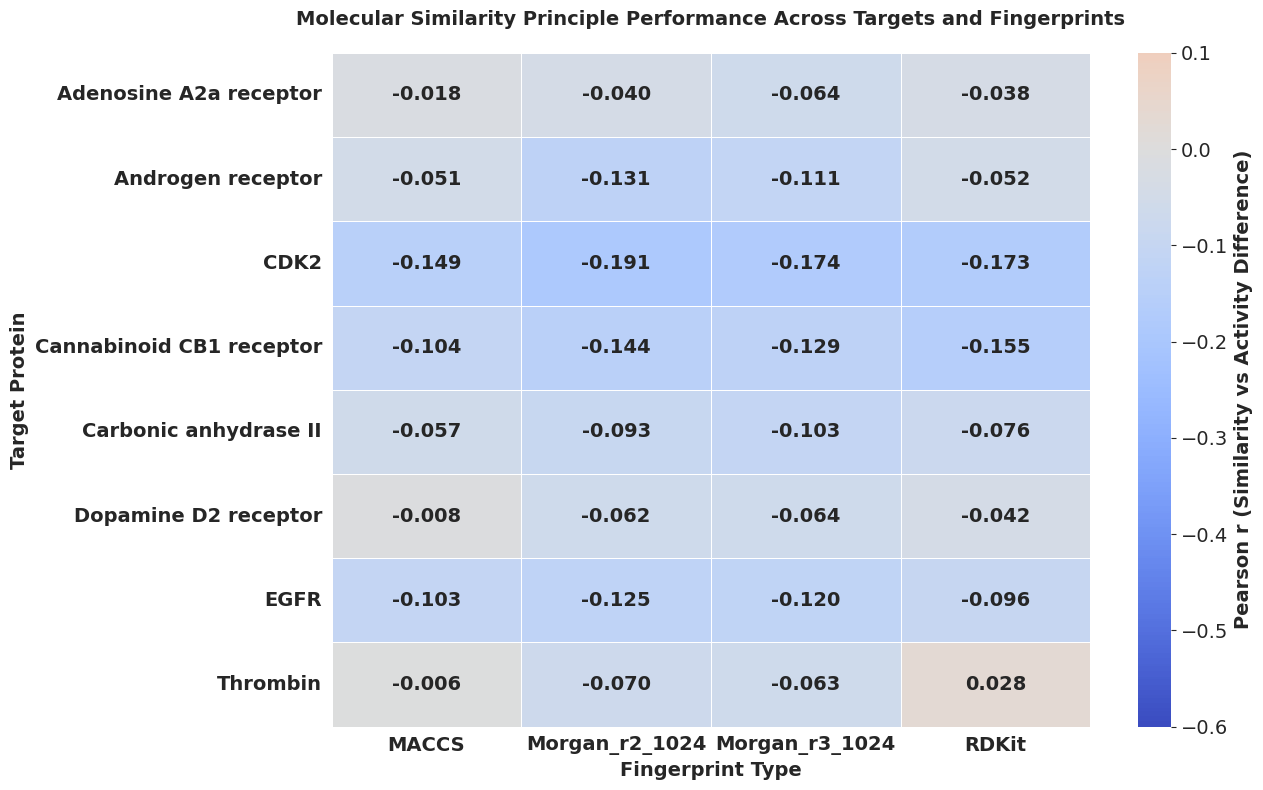

Figure 2: Family-wise performance...


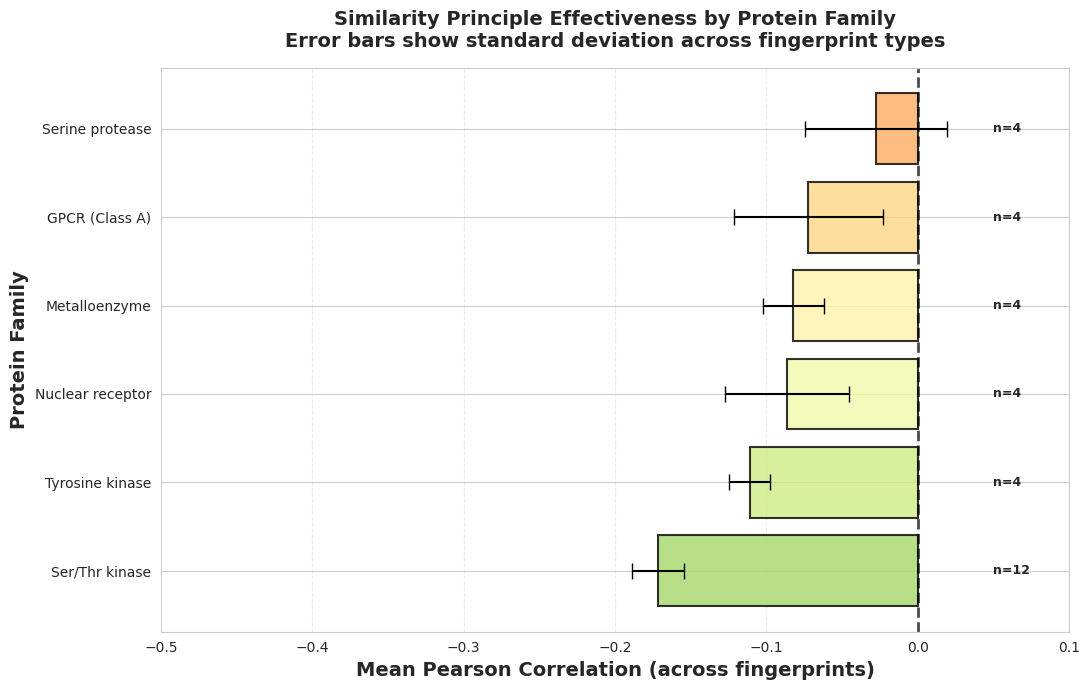

Figure 3: Fingerprint comparison...


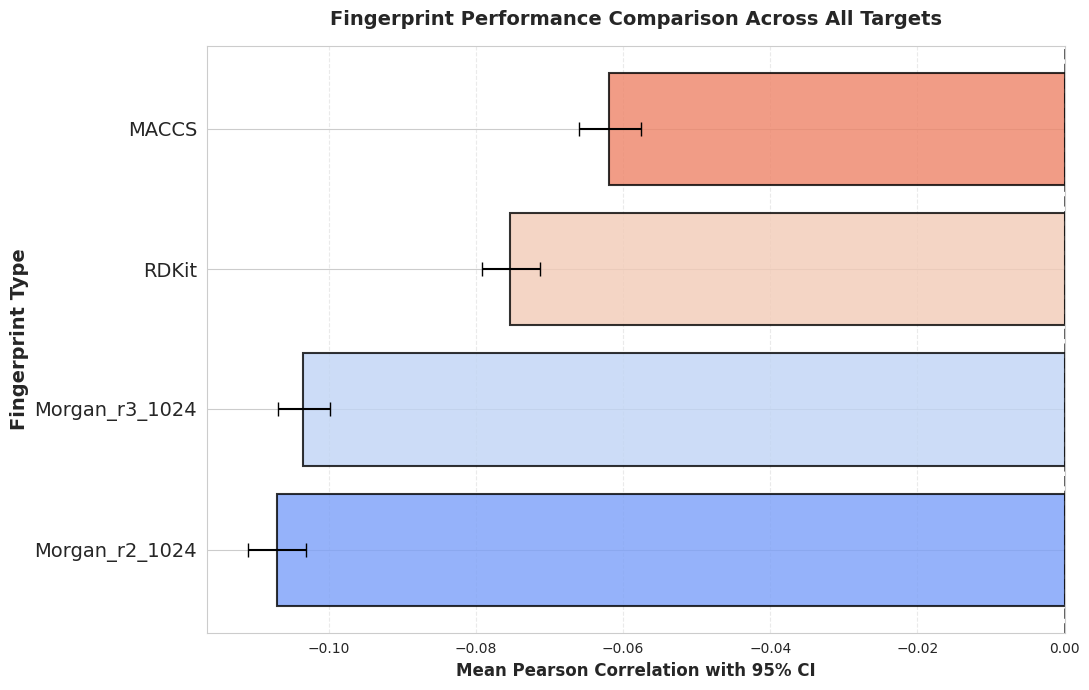

Figure 4: Activity cliffs...


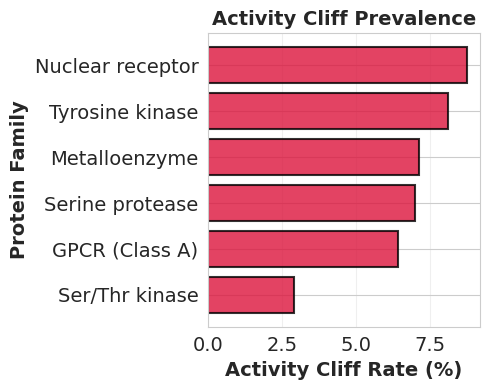

In [4]:
# FIGURE 1: Comprehensive Heatmap (Targets × Fingerprints)
print("\nFigure 1: Correlation heatmap...")
fig, ax = plt.subplots(figsize=(13, 8))
pivot_data = core_results.pivot_table(
    index='Target_Name',
    columns='Fingerprint',
    values='Pearson_r',
    aggfunc='mean'
)
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, vmin=-0.6, vmax=0.1, linewidths=0.5, annot_kws={'size': 14, 'weight': 'bold'},
            cbar_kws={'label': 'Pearson r (Similarity vs Activity Difference)'}, ax=ax)
ax.set_title('Molecular Similarity Principle Performance Across Targets and Fingerprints', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Fingerprint Type', fontsize=14, fontweight='bold')
ax.set_ylabel('Target Protein', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.label.set_size(14)
cbar.ax.yaxis.label.set_fontweight('bold')
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

for label in ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig('fig1_correlation_heatmap.png', dpi=600, bbox_inches='tight')
plt.show()

# FIGURE 2: Performance by Protein Family with Error Bars
print("Figure 2: Family-wise performance...")
fig, ax = plt.subplots(figsize=(11, 7))
family_stats = core_results.groupby('Family').agg({
    'Pearson_r': ['mean', 'std', 'count']
}).reset_index()
family_stats.columns = ['Family', 'Mean', 'Std', 'Count']
family_stats = family_stats.sort_values('Mean')

colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(family_stats)))
ax.barh(family_stats['Family'], family_stats['Mean'],
        xerr=family_stats['Std'], capsize=6, alpha=0.8,
        color=colors, edgecolor='black', linewidth=1.5)
ax.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Mean Pearson Correlation (across fingerprints)', fontsize=14, fontweight='bold')
ax.set_ylabel('Protein Family', fontsize=14, fontweight='bold')
ax.set_title('Similarity Principle Effectiveness by Protein Family\n' +
             'Error bars show standard deviation across fingerprint types',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.4, linestyle='--')
ax.set_xlim(-0.5, 0.1)

# Add sample sizes
for idx, row in family_stats.iterrows():
    ax.text(0.05, idx, f'n={int(row["Count"])}',
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('fig2_family_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# FIGURE 3: Fingerprint Comparison with Confidence Intervals
print("Figure 3: Fingerprint comparison...")
fig, ax = plt.subplots(figsize=(11, 7))
fp_stats = core_results.groupby('Fingerprint').agg({
    'Pearson_r': 'mean',
    'CI_Lower': 'mean',
    'CI_Upper': 'mean'
}).reset_index()
fp_stats = fp_stats.sort_values('Pearson_r')

colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(fp_stats)))
y_pos = np.arange(len(fp_stats))
ax.barh(y_pos, fp_stats['Pearson_r'],
        xerr=[fp_stats['Pearson_r'] - fp_stats['CI_Lower'],
              fp_stats['CI_Upper'] - fp_stats['Pearson_r']],
        capsize=5, alpha=0.8, color=colors,
        edgecolor='black', linewidth=1.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(fp_stats['Fingerprint'], fontsize=14)
ax.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Mean Pearson Correlation with 95% CI', fontsize=12, fontweight='bold')
ax.set_ylabel('Fingerprint Type', fontsize=14, fontweight='bold')
ax.set_title('Fingerprint Performance Comparison Across All Targets', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.4, linestyle='--')
plt.tight_layout()
plt.savefig('fig3_fingerprint_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

# FIGURE 4: Activity Cliff Analysis
print("Figure 4: Activity cliffs...")
fig, axes = plt.subplots(figsize=(5, 4))

# 4A: Cliff rate by family
cliff_by_family = core_results.groupby('Family')['Cliff_Rate'].mean().sort_values()
axes.barh(cliff_by_family.index, cliff_by_family.values * 100,
            alpha=0.8, color='crimson', edgecolor='black', linewidth=1.5)
axes.set_xlabel('Activity Cliff Rate (%)', fontsize=14, fontweight='bold')
axes.set_ylabel('Protein Family', fontsize=14, fontweight='bold')
axes.set_title('Activity Cliff Prevalence', fontsize=14, fontweight='bold')
axes.grid(axis='x', alpha=0.3)
axes.tick_params(axis='x', labelsize=14)
axes.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig('fig4_activity_cliffs.png', dpi=600, bbox_inches='tight')
plt.show()


Figure 5: ML performance...


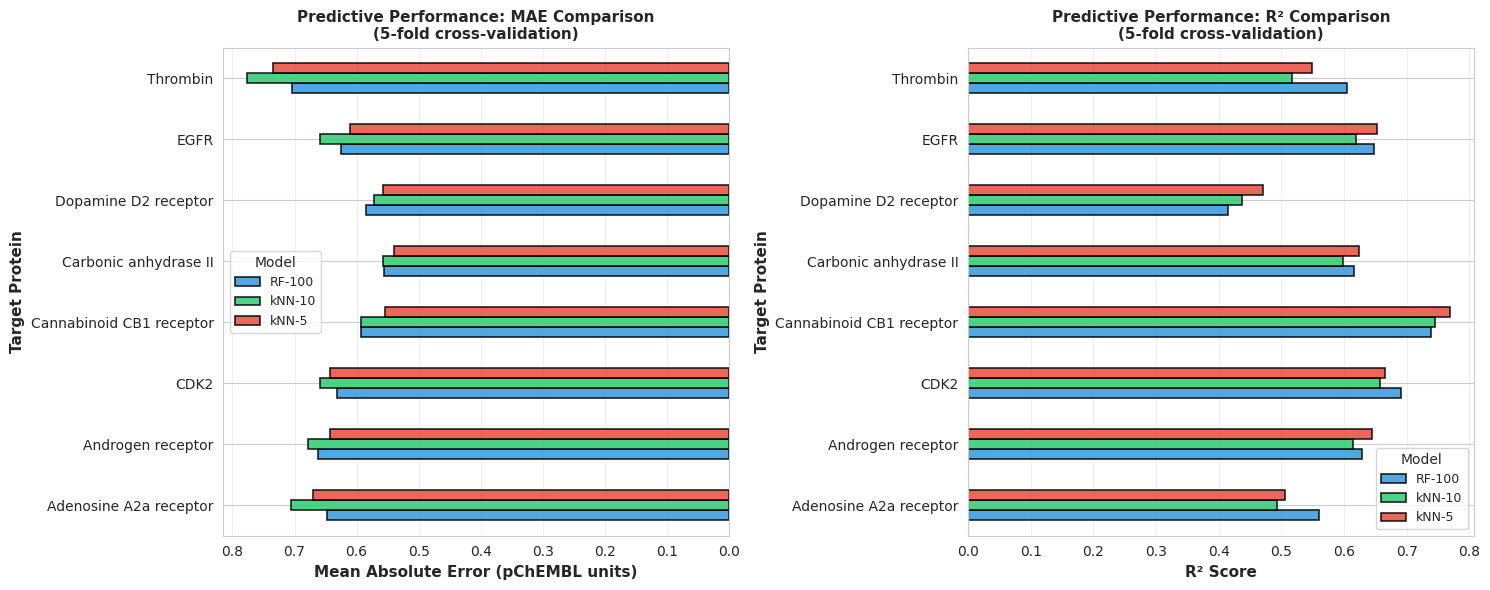

Figure 6: Ablation studies...


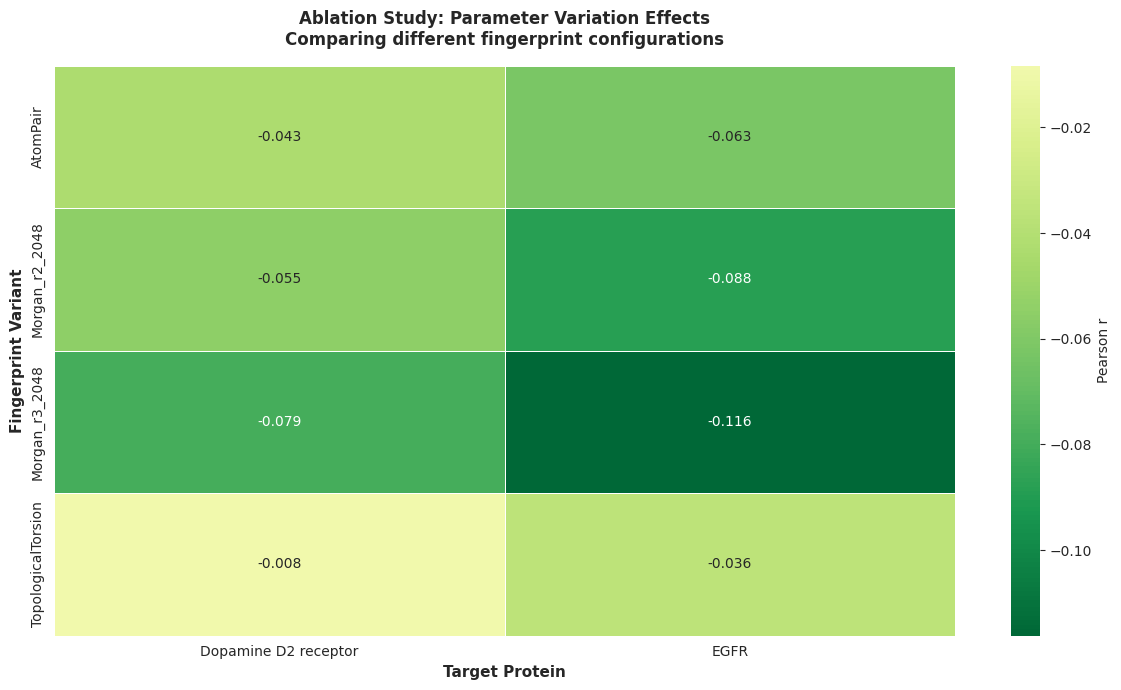

Figure 7: Target-specific recommendations...


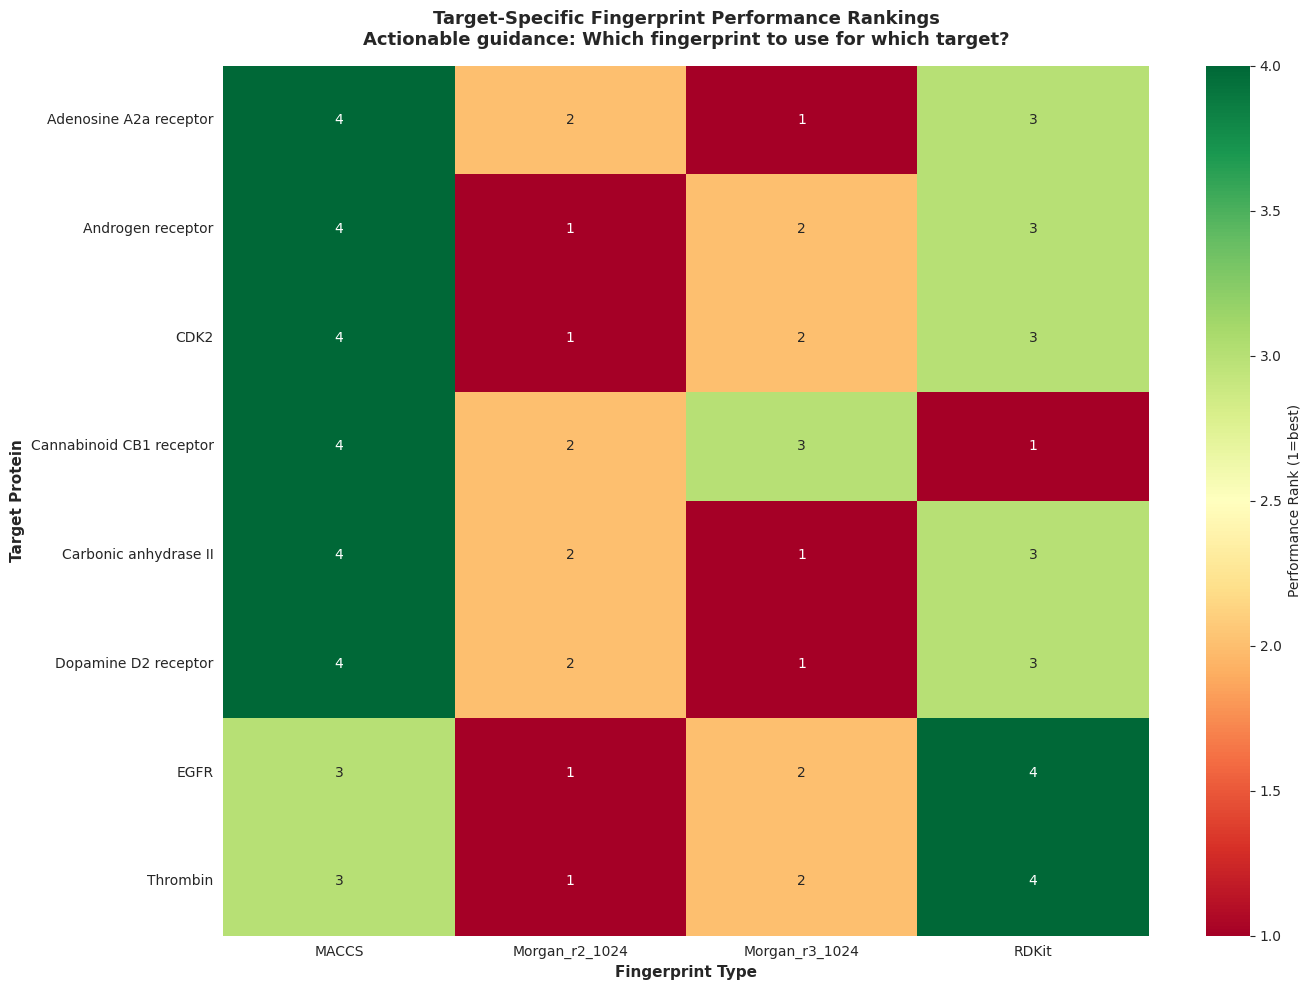

In [5]:
# FIGURE 5: Predictive Modeling Performance
print("Figure 5: ML performance...")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 5A: MAE comparison
mae_pivot = pred_df.pivot(index='Target', columns='Model', values='MAE')
mae_pivot.plot(kind='barh', ax=axes[0], color=['#3498db', '#2ecc71', '#e74c3c'],
              edgecolor='black', linewidth=1.2, alpha=0.85)
axes[0].set_xlabel('Mean Absolute Error (pChEMBL units)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Target Protein', fontsize=11, fontweight='bold')
axes[0].set_title('Predictive Performance: MAE Comparison\n(5-fold cross-validation)',
                  fontsize=11, fontweight='bold')
axes[0].legend(title='Model', fontsize=9)
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_xaxis()

# 5B: R² comparison
r2_pivot = pred_df.pivot(index='Target', columns='Model', values='R2')
r2_pivot.plot(kind='barh', ax=axes[1], color=['#3498db', '#2ecc71', '#e74c3c'],
             edgecolor='black', linewidth=1.2, alpha=0.85)
axes[1].set_xlabel('R² Score', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Target Protein', fontsize=11, fontweight='bold')
axes[1].set_title('Predictive Performance: R² Comparison\n(5-fold cross-validation)',
                  fontsize=11, fontweight='bold')
axes[1].legend(title='Model', fontsize=9)
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

plt.tight_layout()
plt.savefig('fig5_predictive_performance.png', dpi=300, bbox_inches='tight')
plt.savefig('fig5_predictive_performance.pdf', bbox_inches='tight')
plt.show()

# FIGURE 6: Ablation Study Results
print("Figure 6: Ablation studies...")
ablation_results = results_df[results_df['FP_Category'] == 'Ablation']

if len(ablation_results) > 0:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Compare ablation variants to core
    comparison_data = []
    for target in ablation_results['Target_Name'].unique():
        core_mean = core_results[core_results['Target_Name'] == target]['Pearson_r'].mean()

        for fp in ablation_results['Fingerprint'].unique():
            ablation_val = ablation_results[
                (ablation_results['Target_Name'] == target) &
                (ablation_results['Fingerprint'] == fp)
            ]['Pearson_r'].values

            if len(ablation_val) > 0:
                comparison_data.append({
                    'Target': target,
                    'Fingerprint': fp,
                    'Pearson_r': ablation_val[0],
                    'Core_Mean': core_mean,
                    'Difference': ablation_val[0] - core_mean
                })

    comp_df = pd.DataFrame(comparison_data)
    pivot_comp = comp_df.pivot(index='Fingerprint', columns='Target', values='Pearson_r')

    sns.heatmap(pivot_comp, annot=True, fmt='.3f', cmap='RdYlGn_r',
                center=0, linewidths=0.5, cbar_kws={'label': 'Pearson r'}, ax=ax)
    ax.set_title('Ablation Study: Parameter Variation Effects\n' +
                 'Comparing different fingerprint configurations',
                 fontsize=12, fontweight='bold', pad=15)
    ax.set_xlabel('Target Protein', fontsize=11, fontweight='bold')
    ax.set_ylabel('Fingerprint Variant', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig('fig6_ablation_study.png', dpi=300, bbox_inches='tight')
    plt.savefig('fig6_ablation_study.pdf', bbox_inches='tight')
    plt.show()

# FIGURE 7: Target-Specific Recommendations
print("Figure 7: Target-specific recommendations...")
fig, ax = plt.subplots(figsize=(14, 10))

# For each target, show best performing fingerprint
target_best_fp = core_results.loc[
    core_results.groupby('Target_Name')['Pearson_r'].idxmin()
][['Target_Name', 'Fingerprint', 'Pearson_r', 'Family']]

# Create matrix showing rank of each fingerprint per target
rank_data = []
for target in core_results['Target_Name'].unique():
    target_data = core_results[core_results['Target_Name'] == target].sort_values('Pearson_r')
    for rank, (_, row) in enumerate(target_data.iterrows(), 1):
        rank_data.append({
            'Target': target,
            'Fingerprint': row['Fingerprint'],
            'Rank': rank,
            'Pearson_r': row['Pearson_r']
        })

rank_df = pd.DataFrame(rank_data)
pivot_rank = rank_df.pivot(index='Target', columns='Fingerprint', values='Rank')

sns.heatmap(pivot_rank, annot=True, fmt='g', cmap='RdYlGn',
            cbar_kws={'label': 'Performance Rank (1=best)'}, ax=ax)
ax.set_title('Target-Specific Fingerprint Performance Rankings\n' +
             'Actionable guidance: Which fingerprint to use for which target?',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Fingerprint Type', fontsize=11, fontweight='bold')
ax.set_ylabel('Target Protein', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('fig7_target_recommendations.png', dpi=300, bbox_inches='tight')
plt.savefig('fig7_target_recommendations.pdf', bbox_inches='tight')
plt.show()

Figure 8: Activity cliff structures...


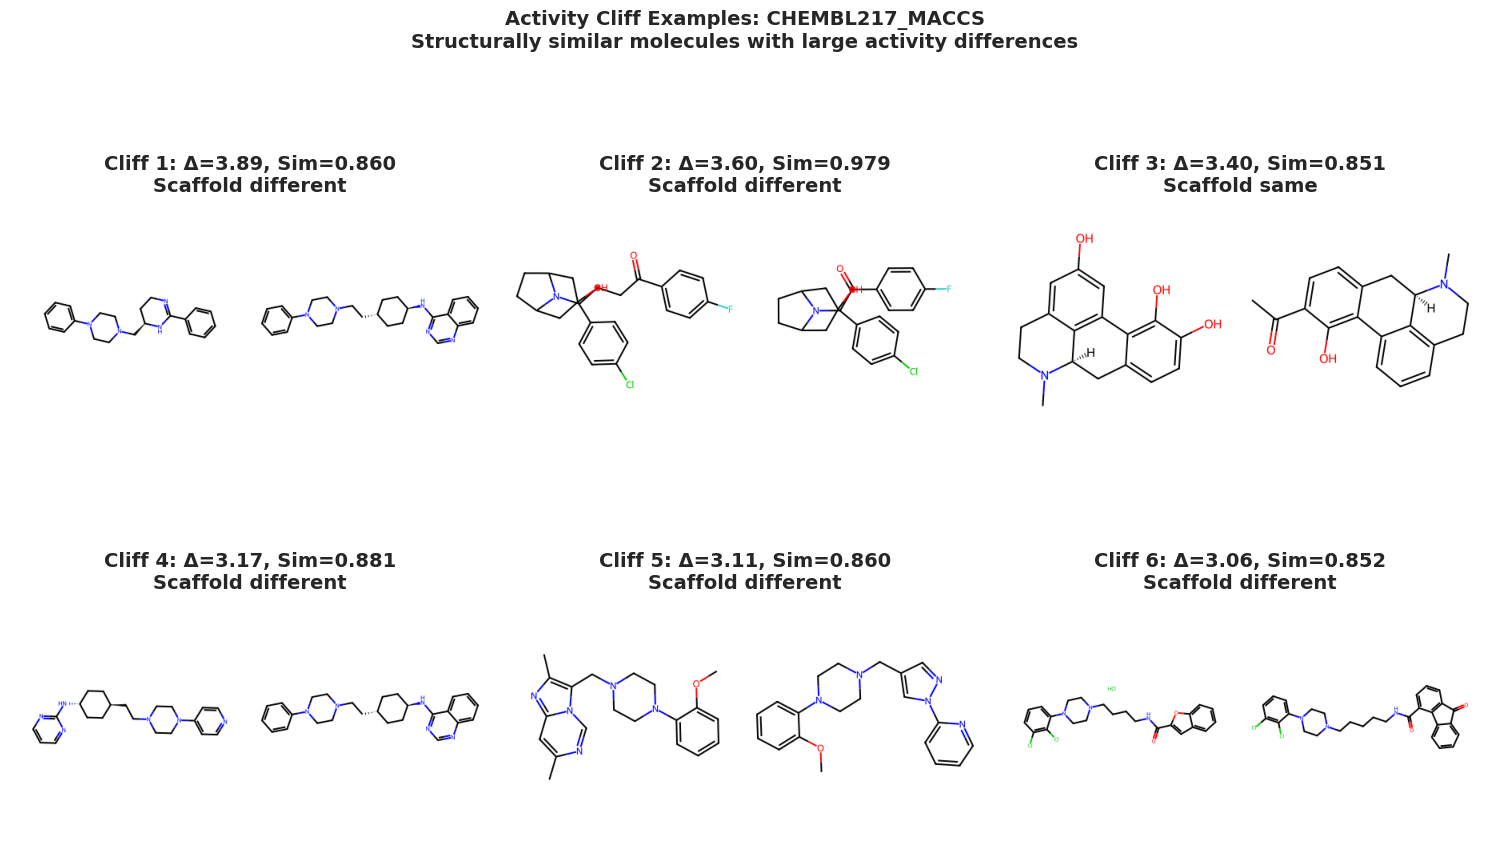

In [11]:
print("Figure 8: Activity cliff structures...")
import numpy as np  # Place imports at top of function/block for clarity
from rdkit.Chem.Draw import rdMolDraw2D

# Create drawing options object and set legend font size
draw_options = rdMolDraw2D.MolDrawOptions()
draw_options.legendFontSize = 14

if len(activity_cliffs_all) > 0:
    # Select one target with cliffs for detailed visualization
    example_key = list(activity_cliffs_all.keys())[0]
    example_cliffs = activity_cliffs_all[example_key]

    if len(example_cliffs) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        # Show top 6 activity cliffs by largest activity difference
        top_cliffs = example_cliffs.nlargest(6, 'activity_diff')

        for idx, (_, cliff) in enumerate(top_cliffs.iterrows()):
            mol_i = Chem.MolFromSmiles(cliff['smiles_i'])
            mol_j = Chem.MolFromSmiles(cliff['smiles_j'])

            # Generate grid image of molecule pair
            img = Draw.MolsToGridImage(
              [mol_i, mol_j],
              molsPerRow=2,
              subImgSize=(300, 300),
              #legends=[f"pChEMBL={cliff['pchembl_i']:.2f}",
              #  f"pChEMBL={cliff['pchembl_j']:.2f}"],
              useSVG=False,
              returnPNG=False,  # This forces returning a PIL Image
              drawOptions=draw_options
            )

            # Ensure img is PIL Image, convert to RGB for consistent format
            if not hasattr(img, "convert"):
                raise TypeError(f"Expected PIL Image, got {type(img)}")
            img_rgb = img.convert('RGB')
            img_np = np.array(img_rgb)

            # Display image in subplot
            axes[idx].imshow(img_np)
            axes[idx].axis('off')
            axes[idx].set_title(
                f"Cliff {idx+1}: Δ={cliff['activity_diff']:.2f}, Sim={cliff['similarity']:.3f}\n" +
                f"Scaffold {'same' if cliff['same_scaffold'] else 'different'}",
                fontsize=14, fontweight='bold'
            )

        # Hide any unused subplots
        for idx in range(len(top_cliffs), 6):
            axes[idx].axis('off')

        plt.suptitle(
            f'Activity Cliff Examples: {example_key}\n' +
            'Structurally similar molecules with large activity differences',
            fontsize=14, fontweight='bold'
        )
        plt.tight_layout()
        plt.savefig('fig8_activity_cliff_structures.png', dpi=600, bbox_inches='tight')
        plt.show()

Figure 9: Statistical significance...


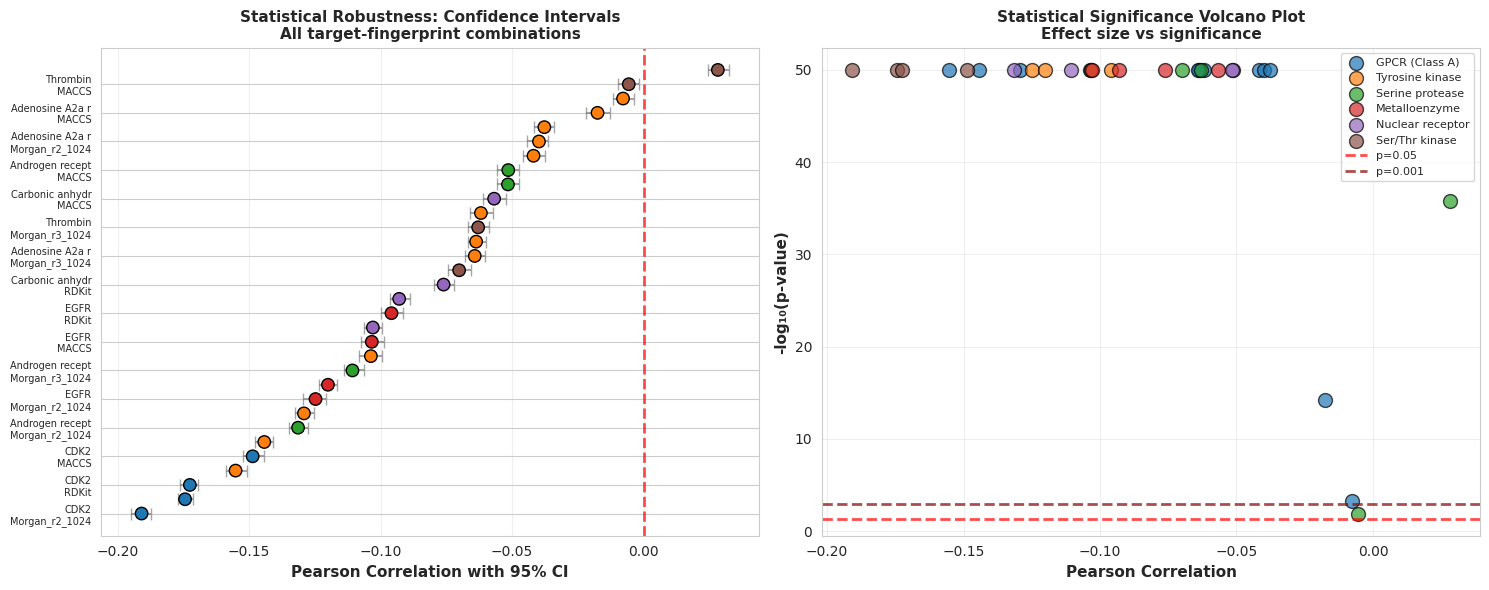

Figure 10: Chemical space diversity...


[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerator
[12:32:28] DEPRECATION WARNING: please use MorganGenerat

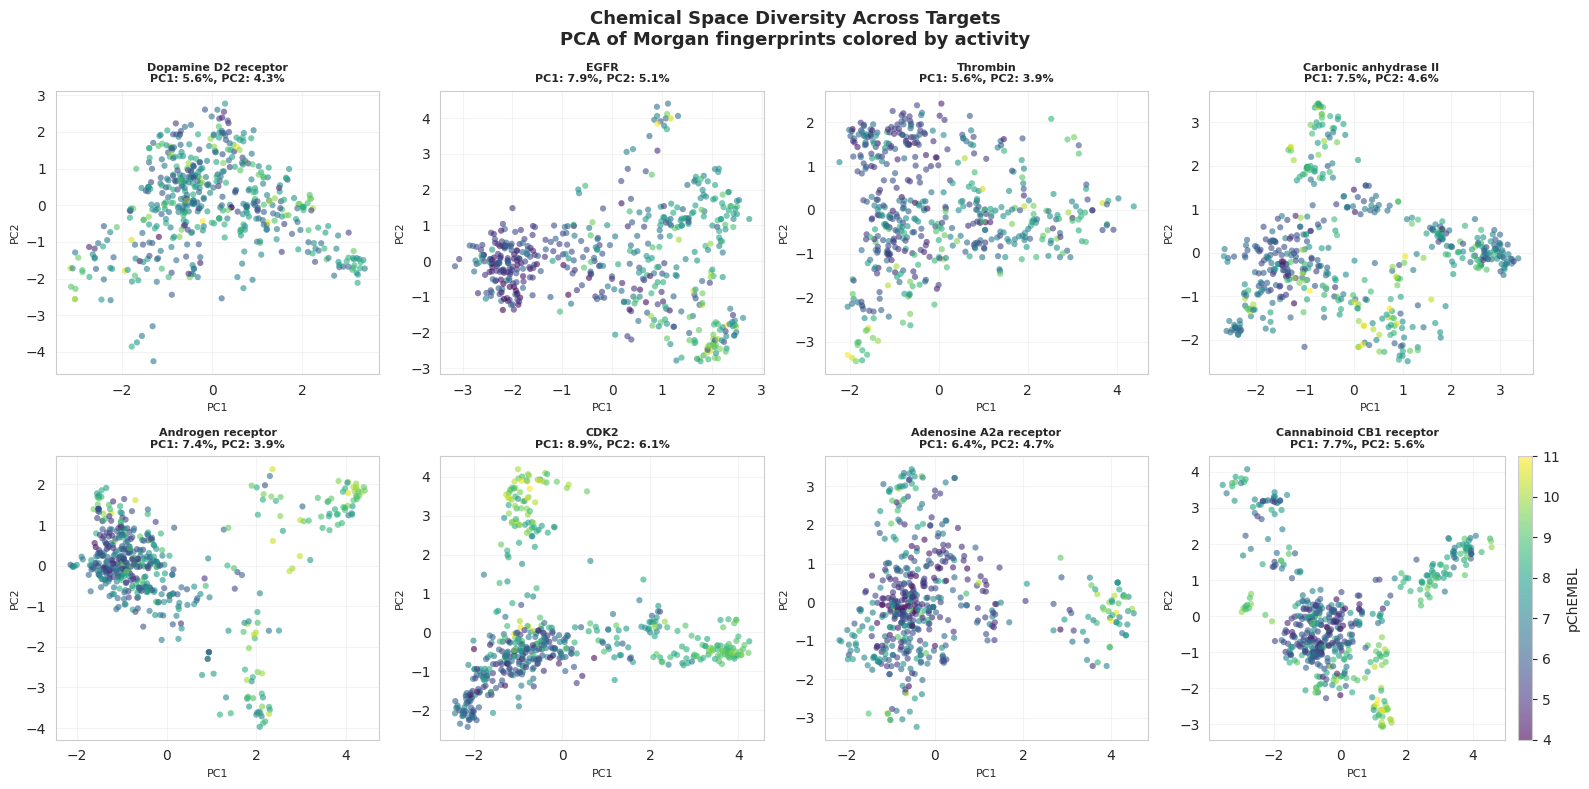


✓ All figures generated


In [7]:

# FIGURE 9: Statistical Robustness
print("Figure 9: Statistical significance...")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 9A: Confidence interval forest plot
core_sorted = core_results.sort_values('Pearson_r').reset_index(drop=True)
y_pos = np.arange(len(core_sorted))

# Color by family
family_colors = {fam: plt.cm.tab10(i) for i, fam in enumerate(core_sorted['Family'].unique())}
colors = [family_colors[fam] for fam in core_sorted['Family']]

axes[0].errorbar(core_sorted['Pearson_r'], y_pos,
                xerr=[core_sorted['Pearson_r'] - core_sorted['CI_Lower'],
                      core_sorted['CI_Upper'] - core_sorted['Pearson_r']],
                fmt='o', markersize=6, capsize=4, alpha=0.7,
                ecolor='gray', elinewidth=1.5)
axes[0].scatter(core_sorted['Pearson_r'], y_pos, c=colors, s=80,
               edgecolors='black', linewidth=1, zorder=3)

axes[0].axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[0].set_yticks(y_pos[::2])
axes[0].set_yticklabels([f"{row['Target_Name'][:15]}\n{row['Fingerprint']}"
                         for _, row in core_sorted.iloc[::2].iterrows()], fontsize=7)
axes[0].set_xlabel('Pearson Correlation with 95% CI', fontsize=11, fontweight='bold')
axes[0].set_title('Statistical Robustness: Confidence Intervals\n' +
                 'All target-fingerprint combinations',
                 fontsize=11, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# 9B: P-value volcano plot
core_with_p = core_results[core_results['Pearson_p'].notna()]
core_with_p['neg_log_p'] = -np.log10(core_with_p['Pearson_p'].clip(lower=1e-50))

for family in core_with_p['Family'].unique():
    fam_data = core_with_p[core_with_p['Family'] == family]
    axes[1].scatter(fam_data['Pearson_r'], fam_data['neg_log_p'],
                   label=family, s=100, alpha=0.7, edgecolors='black', linewidth=1)

axes[1].axhline(-np.log10(0.05), color='red', linestyle='--',
               linewidth=2, label='p=0.05', alpha=0.7)
axes[1].axhline(-np.log10(0.001), color='darkred', linestyle='--',
               linewidth=2, label='p=0.001', alpha=0.7)
axes[1].set_xlabel('Pearson Correlation', fontsize=11, fontweight='bold')
axes[1].set_ylabel('-log₁₀(p-value)', fontsize=11, fontweight='bold')
axes[1].set_title('Statistical Significance Volcano Plot\n' +
                 'Effect size vs significance',
                 fontsize=11, fontweight='bold')
axes[1].legend(fontsize=8, loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig9_statistical_robustness.png', dpi=300, bbox_inches='tight')
plt.savefig('fig9_statistical_robustness.pdf', bbox_inches='tight')
plt.show()

# FIGURE 10: Chemical Space Analysis
print("Figure 10: Chemical space diversity...")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (target_id, df) in enumerate(target_datasets.items()):
    if idx >= 8:
        break

    # Sample for PCA
    sample_df = df.sample(n=min(500, len(df)), random_state=42)

    # Generate Morgan FPs
    fps = []
    for mol in sample_df['mol']:
        fp = FingerprintLibrary.morgan_r2_1024(mol)
        if fp:
            fps.append(np.array(fp, dtype=np.float32))

    if len(fps) < 50:
        axes[idx].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
        axes[idx].set_title(TARGETS[target_id]['name'][:20], fontsize=9)
        continue

    # PCA
    pca = PCA(n_components=2, random_state=42)
    fps_2d = pca.fit_transform(fps)

    # Color by activity
    activities = sample_df.iloc[:len(fps)]['pchembl_value'].values
    scatter = axes[idx].scatter(fps_2d[:, 0], fps_2d[:, 1],
                               c=activities, cmap='viridis',
                               s=20, alpha=0.6, edgecolors='none')

    axes[idx].set_title(f"{TARGETS[target_id]['name'][:25]}\n" +
                       f"PC1: {pca.explained_variance_ratio_[0]:.1%}, " +
                       f"PC2: {pca.explained_variance_ratio_[1]:.1%}",
                       fontsize=8, fontweight='bold')
    axes[idx].set_xlabel('PC1', fontsize=8)
    axes[idx].set_ylabel('PC2', fontsize=8)
    axes[idx].grid(True, alpha=0.2)

    # Colorbar for last plot only
    if idx == 7 or idx == len(target_datasets) - 1:
        plt.colorbar(scatter, ax=axes[idx], label='pChEMBL', fraction=0.046, pad=0.04)

plt.suptitle('Chemical Space Diversity Across Targets\n' +
            'PCA of Morgan fingerprints colored by activity',
            fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig10_chemical_space.png', dpi=300, bbox_inches='tight')
plt.savefig('fig10_chemical_space.pdf', bbox_inches='tight')
plt.show()

print("\n✓ All figures generated")


In [8]:
# ============================================================================
# SECTION 14: KEY FINDINGS AND INSIGHTS
# ============================================================================

print("\n" + "=" * 80)
print("KEY FINDINGS AND INSIGHTS FOR PUBLICATION")
print("=" * 80)

print("\n1. OVERALL PERFORMANCE METRICS")
print("-" * 80)
print(f"Total analyses performed: {len(results_df)}")
print(f"Mean Pearson r: {core_results['Pearson_r'].mean():.3f} ± {core_results['Pearson_r'].std():.3f}")
print(f"Range: [{core_results['Pearson_r'].min():.3f}, {core_results['Pearson_r'].max():.3f}]")
print(f"Statistically significant (p<0.05): {(core_results['Pearson_p'] < 0.05).sum()}/{len(core_results)}")

print("\n2. BEST PERFORMING COMBINATIONS (Target-Fingerprint)")
print("-" * 80)
top10 = core_results.nsmallest(10, 'Pearson_r')[
    ['Target_Name', 'Fingerprint', 'Pearson_r', 'CI_Lower', 'CI_Upper', 'Family']
]
for idx, row in top10.iterrows():
    print(f"{row['Target_Name'][:30]:30s} | {row['Fingerprint']:15s} | " +
          f"r={row['Pearson_r']:.3f} [{row['CI_Lower']:.3f}, {row['CI_Upper']:.3f}] | {row['Family']}")

print("\n3. FAMILY-SPECIFIC INSIGHTS")
print("-" * 80)
family_summary = core_results.groupby('Family').agg({
    'Pearson_r': ['mean', 'std', 'min', 'max', 'count']
}).round(3)
print(family_summary)

print("\n4. FINGERPRINT RANKINGS (Averaged Across Targets)")
print("-" * 80)
fp_ranking = core_results.groupby('Fingerprint').agg({
    'Pearson_r': 'mean',
    'Cliff_Rate': 'mean',
    'Mean_Similarity': 'mean'
}).sort_values('Pearson_r')
print(fp_ranking.to_string())

print("\n5. ACTIVITY CLIFF STATISTICS")
print("-" * 80)
print(f"Total activity cliffs detected: {core_results['Activity_Cliffs'].sum()}")
print(f"Mean cliff rate: {core_results['Cliff_Rate'].mean()*100:.2f}%")
print(f"Highest cliff rate: {core_results['Cliff_Rate'].max()*100:.2f}% " +
      f"({core_results.loc[core_results['Cliff_Rate'].idxmax(), 'Target_Name']} - " +
      f"{core_results.loc[core_results['Cliff_Rate'].idxmax(), 'Fingerprint']})")

print("\n6. PREDICTIVE MODELING PERFORMANCE")
print("-" * 80)
print("Best MAE per target:")
for target in pred_df['Target'].unique():
    target_data = pred_df[pred_df['Target'] == target]
    best = target_data.loc[target_data['MAE'].idxmin()]
    print(f"  {target[:30]:30s} | {best['Model']:10s} | MAE={best['MAE']:.3f}±{best['MAE_std']:.3f}")

print("\nBest R² per target:")
for target in pred_df['Target'].unique():
    target_data = pred_df[pred_df['Target'] == target]
    best = target_data.loc[target_data['R2'].idxmax()]
    print(f"  {target[:30]:30s} | {best['Model']:10s} | R²={best['R2']:.3f}")

print("\n7. TARGET-SPECIFIC FINGERPRINT RECOMMENDATIONS")
print("-" * 80)
print("Recommended fingerprint for each target (best performing):")
for target in core_results['Target_Name'].unique():
    target_data = core_results[core_results['Target_Name'] == target]
    best = target_data.loc[target_data['Pearson_r'].idxmin()]
    print(f"  {target[:35]:35s} → {best['Fingerprint']:15s} (r={best['Pearson_r']:.3f})")

if len(results_df[results_df['FP_Category'] == 'Ablation']) > 0:
    print("\n8. ABLATION STUDY INSIGHTS")
    print("-" * 80)
    ablation_data = results_df[results_df['FP_Category'] == 'Ablation']
    print("Effect of parameter variations:")

    # Compare radius effects
    radius_comparison = []
    for target in ablation_data['Target_Name'].unique():
        r2_val = core_results[
            (core_results['Target_Name'] == target) &
            (core_results['Fingerprint'] == 'Morgan_r2_1024')
        ]['Pearson_r'].values

        r3_val = ablation_data[
            (ablation_data['Target_Name'] == target) &
            (ablation_data['Fingerprint'] == 'Morgan_r3_2048')
        ]['Pearson_r'].values

        if len(r2_val) > 0 and len(r3_val) > 0:
            radius_comparison.append({
                'Target': target,
                'r2': r2_val[0],
                'r3': r3_val[0],
                'Difference': r3_val[0] - r2_val[0]
            })

    if radius_comparison:
        rc_df = pd.DataFrame(radius_comparison)
        print("\n  Radius effect (r3 vs r2):")
        print(f"    Mean difference: {rc_df['Difference'].mean():.4f}")
        print(f"    r3 better in {(rc_df['Difference'] < 0).sum()}/{len(rc_df)} cases")

if DEEP_LEARNING_AVAILABLE and 'ChemBERTa' in results_df['Fingerprint'].values:
    print("\n9. DEEP LEARNING vs CLASSICAL FINGERPRINTS")
    print("-" * 80)
    dl_results = results_df[results_df['Fingerprint'] == 'ChemBERTa']

    for _, dl_row in dl_results.iterrows():
        target = dl_row['Target_Name']
        classical_best = core_results[
            core_results['Target_Name'] == target
        ]['Pearson_r'].min()

        improvement = dl_row['Pearson_r'] - classical_best
        status = "better" if improvement < 0 else "worse"

        print(f"  {target[:30]:30s} | ChemBERTa: {dl_row['Pearson_r']:.3f} | " +
              f"Best classical: {classical_best:.3f} | Δ={improvement:.3f} ({status})")

print("\n10. CHEMICAL SPACE DIVERSITY METRICS")
print("-" * 80)
for target_id, df in target_datasets.items():
    print(f"\n  {TARGETS[target_id]['name']}:")
    print(f"    MW range: {df['mw'].min():.1f} - {df['mw'].max():.1f} Da")
    print(f"    pChEMBL range: {df['pchembl_value'].min():.2f} - {df['pchembl_value'].max():.2f}")
    print(f"    pChEMBL std: {df['pchembl_value'].std():.2f}")

# ============================================================================
# SECTION 15: SAVE ALL RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

# Save main results
results_df.to_csv('comprehensive_results.csv', index=False)
pred_df.to_csv('predictive_modeling_results.csv', index=False)

# Save activity cliffs
for key, cliffs_df in activity_cliffs_all.items():
    cliffs_df.to_csv(f'activity_cliffs_{key}.csv', index=False)

# Save target-specific recommendations
recommendations = []
for target in core_results['Target_Name'].unique():
    target_data = core_results[core_results['Target_Name'] == target].sort_values('Pearson_r')

    recommendations.append({
        'Target': target,
        'Family': target_data.iloc[0]['Family'],
        'Best_Fingerprint': target_data.iloc[0]['Fingerprint'],
        'Best_Pearson_r': target_data.iloc[0]['Pearson_r'],
        'Worst_Fingerprint': target_data.iloc[-1]['Fingerprint'],
        'Worst_Pearson_r': target_data.iloc[-1]['Pearson_r'],
        'Performance_Range': target_data.iloc[-1]['Pearson_r'] - target_data.iloc[0]['Pearson_r']
    })

recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_csv('target_specific_recommendations.csv', index=False)

print("✓ Saved comprehensive_results.csv")
print("✓ Saved predictive_modeling_results.csv")
print(f"✓ Saved {len(activity_cliffs_all)} activity cliff files")
print("✓ Saved target_specific_recommendations.csv")



KEY FINDINGS AND INSIGHTS FOR PUBLICATION

1. OVERALL PERFORMANCE METRICS
--------------------------------------------------------------------------------
Total analyses performed: 43
Mean Pearson r: -0.087 ± 0.054
Range: [-0.191, 0.028]
Statistically significant (p<0.05): 32/32

2. BEST PERFORMING COMBINATIONS (Target-Fingerprint)
--------------------------------------------------------------------------------
CDK2                           | Morgan_r2_1024  | r=-0.191 [-0.195, -0.187] | Ser/Thr kinase
CDK2                           | Morgan_r3_1024  | r=-0.174 [-0.177, -0.171] | Ser/Thr kinase
CDK2                           | RDKit           | r=-0.173 [-0.176, -0.169] | Ser/Thr kinase
Cannabinoid CB1 receptor       | RDKit           | r=-0.155 [-0.159, -0.151] | GPCR (Class A)
CDK2                           | MACCS           | r=-0.149 [-0.152, -0.144] | Ser/Thr kinase
Cannabinoid CB1 receptor       | Morgan_r2_1024  | r=-0.144 [-0.148, -0.141] | GPCR (Class A)
Androgen receptor   